# Linear regression for microcredit treatment effect

This notebooks corresponds to the experiments of Section 6.2 of the supplementary materials

In [ ]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from src.studentT_prior_lin_reg import StudentTLinReg
from src.weights_optimizer import WeightsOptimizer
from src.utils import to_np

# Prepare the data

In [2]:
df = pd.read_stata("../data/angelucci_et_al_2015.dta")

target_var = "Q10_9_toprof"

# Keep observations with no NA in treatment. Impute NAs with zero in target_var
df = df.dropna(subset=['Treatment'])
df[target_var] = df[target_var].fillna(0)

# Mean of target_var by Treatment
df.groupby('Treatment')[target_var].mean()

# Standardize target_var
df[target_var] = df[target_var] * 0.1026493 # Standarizer that they use in the paper

In [3]:
X = df['Treatment'].values
y = df[target_var].values

data = {"X": torch.tensor(X), "y": torch.tensor(y)}

In [4]:
model = StudentTLinReg()
samples_orig = model.sample_posterior(4000, data, warmup_steps=1000)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Slope mean and std: -4.71491813659668 +- 6.023346424102783


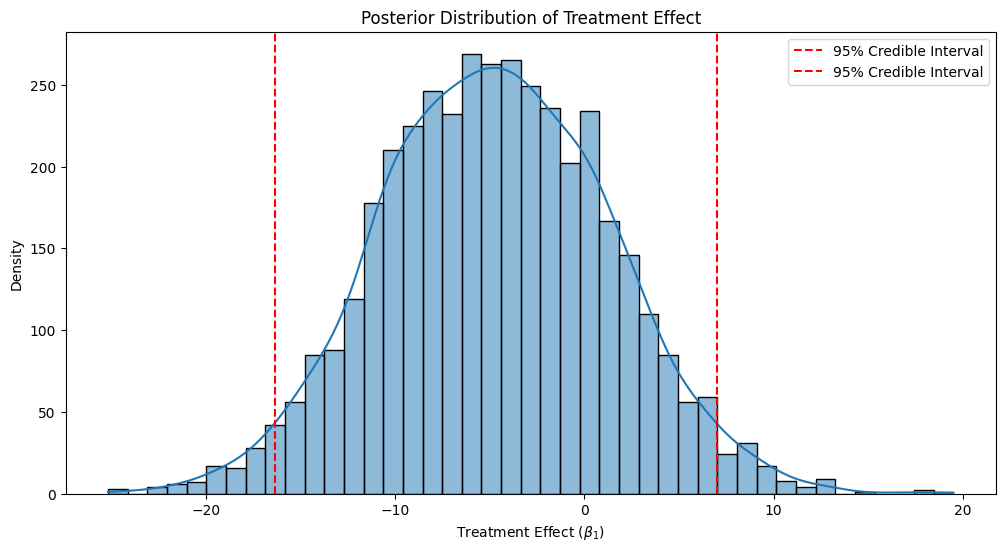

In [5]:
slope_samples = samples_orig["beta_1"]

print("Slope mean and std:", float(slope_samples.mean()), "+-", float(slope_samples.std()))
# Plot posterior for the treatment effect slope. Plot also 90% credible interval
plt.figure(figsize=(12, 6))
sns.histplot(slope_samples, kde=True)
plt.axvline(np.percentile(slope_samples, 2.5), color='red', linestyle='--', label='95% Credible Interval')
plt.axvline(np.percentile(slope_samples, 97.5), color='red', linestyle='--', label='95% Credible Interval')
plt.xlabel('Treatment Effect ($\\beta_1$)')
plt.ylabel('Density')
plt.title('Posterior Distribution of Treatment Effect')
plt.legend()
plt.show()


# Adversarial attacks

In [6]:
CLR_ORIGINAL = "Green"
CLR_TARGET = "Red"
CLR_TAINTED = "Blue"

colors = [CLR_ORIGINAL, CLR_TARGET, CLR_TAINTED]

AX_LBL_SIZE = 22
TICKS_LBL_SIZE = 15
LEGEND_LBL_SIZE = 15

## Functions definitions

In [7]:
def plot_points(weights, pt_size=40, markers_size=100):
    plt.figure(figsize=(7, 7))
    np.random.seed(0)

    X_ = X + (np.random.random(size=len(weights)) - 0.5) * 0.3


    # Plot the datapoints
    plt.scatter(X_, y, color="gray", alpha=0.7, s=pt_size) # c=X_train @ original_mean_beta.data.numpy()

    # Plot the + and - symbols
    plt.scatter(X_, y, color="red", marker='_', alpha=(weights < 1).data, s=markers_size)
    plt.scatter(X_, y, color="green", marker='+', alpha=(weights > 1).data, s=markers_size)
    plt.scatter([], [], color="red", marker='_',  label="$w^*_i=0$") # "Removed points"
    plt.scatter([], [], color="green", marker='+', label="$w^*_i=2$") # "Duplicated points"
    plt.grid(True)
    plt.ylabel("Baseline profit", fontsize=AX_LBL_SIZE)
    plt.xlabel("Treatment", fontsize=AX_LBL_SIZE)
    plt.legend(fontsize=LEGEND_LBL_SIZE, loc="upper center")
    plt.xticks(ticks=[0, 1], labels=[0, 1], fontsize=TICKS_LBL_SIZE)
    plt.yticks(fontsize=TICKS_LBL_SIZE)
    plt.xlim(-0.3, 1.3)
    plt.show()

In [8]:
def plot_samples_kde_single_param(samples_orig, samples_target, samples_tainted, xlabel="", xlim=None,  ylim=None,
                                  confidence_interval=True):
    samples_list = (samples_orig, samples_target, samples_tainted)
    labels = ["Original posterior", "Target posterior", "Tainted posterior"]

    plt.figure(figsize=(7, 7))
    alpha = 0.3

    for i in range(3):
        samples = samples_list[i]
        # Betas
        sns.kdeplot(x=samples, color=colors[i], fill=True, alpha=alpha, label=labels[i])
    
    if confidence_interval:
        plt.axvline(np.percentile(samples_tainted, 2.5), color=CLR_TAINTED, linestyle='--') #, label='95% Credible Interval'
        plt.axvline(np.percentile(samples_tainted, 97.5), color=CLR_TAINTED, linestyle='--')
        
        plt.axvline(np.percentile(samples_orig, 2.5), color=CLR_ORIGINAL, linestyle='--') #, label='95% Credible Interval'
        plt.axvline(np.percentile(samples_orig, 97.5), color=CLR_ORIGINAL, linestyle='--')

    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlabel, fontsize=AX_LBL_SIZE)
    plt.ylabel("Density", fontsize=AX_LBL_SIZE)
    plt.xticks(fontsize=TICKS_LBL_SIZE)
    plt.yticks(fontsize=TICKS_LBL_SIZE)
    plt.grid(True)

    plt.legend(fontsize=LEGEND_LBL_SIZE) 
    plt.tight_layout()
    plt.show()
    

In [9]:
def plot_samples_kde_single_param_break_lines(samples_orig, samples_target, samples_tainted, xlabel="", 
                                  confidence_interval=True):
    labels = ["Original posterior", "Target posterior", "Tainted posterior"]

    
    fig, (ax_left, ax_right) = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(7, 7))
    
    # hide the spines between ax and ax2
    ax_left.spines['right'].set_visible(False)
    ax_right.spines['left'].set_visible(False)
    ax_left.yaxis.tick_left()

    alpha = 0.3
    d = .015

    sns.kdeplot(x=samples_orig, ax=ax_left, color=colors[0], fill=True, alpha=alpha, label=labels[0])
    sns.kdeplot(x=samples_tainted, ax=ax_left, color=colors[2], fill=True, alpha=alpha, label=labels[2])

    sns.kdeplot(x=samples_target, ax=ax_right, color=colors[1], fill=True, alpha=alpha, label=labels[1])

    kwargs = dict(transform=ax_left.transAxes, color='k', clip_on=False)
    ax_left.plot((1-d, 1+d), (-d, +d), **kwargs)
    ax_left.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

    kwargs.update(transform=ax_right.transAxes)
    ax_right.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax_right.plot((-d, +d), (-d, +d), **kwargs)
    
    if confidence_interval:
        ax_left.axvline(np.percentile(samples_tainted, 2.5), color=CLR_TAINTED, linestyle='--') #, label='95% Credible Interval'
        ax_left.axvline(np.percentile(samples_tainted, 97.5), color=CLR_TAINTED, linestyle='--')
        
        ax_left.axvline(np.percentile(samples_orig, 2.5), color=CLR_ORIGINAL, linestyle='--') #, label='95% Credible Interval'
        ax_left.axvline(np.percentile(samples_orig, 97.5), color=CLR_ORIGINAL, linestyle='--')

    ax_left.set_ylabel("Density", fontsize=AX_LBL_SIZE)
    ax_left.set_xlabel(None)
    ax_right.set_xlabel(None)
    plt.suptitle(xlabel, y=0.02, fontsize=AX_LBL_SIZE)
    
    ax_left.tick_params(axis='x', labelsize=TICKS_LBL_SIZE)
    ax_left.tick_params(axis='y', labelsize=TICKS_LBL_SIZE)
    ax_right.tick_params(axis='x', labelsize=TICKS_LBL_SIZE)

    ax_left.grid(True)
    ax_right.grid(True)
    
    left_handles, left_labels = ax_left.get_legend_handles_labels()
    right_handles, right_labels = ax_right.get_legend_handles_labels()
    plt.legend(left_handles + right_handles, left_labels + right_labels, 
               fontsize=LEGEND_LBL_SIZE, loc="upper right") 
    plt.tight_layout()
    plt.show()
    

In [10]:
keys = ["beta_0", "beta_1", "sigma"]
xlabels = ["Intercept ($\\beta_0$)", "Treatment Effect ($\\beta_1$)", "Noise level ($\\sigma$)"]

def increase_slope(y_shift, heuristic, plot=True, seed=None, 
                   n_MC_samples_adv=1000, n_MC_samples_post=1000, n_samples_plot=1000,
                   max_L1=1, max_occurences=1, max_iterations=1,
                   warmup_steps=100, warmup_steps_repeat=10):
    
    y_adv = y + y_shift * (X==1)
    data_adv = {"X": torch.tensor(X), "y": torch.tensor(y_adv)}

    sample_adv = lambda n_samples: model.sample_posterior(n_samples, data_adv, warmup_steps=500)
    if seed is not None:
        model.seed = seed
    opti = WeightsOptimizer(data, model, sample_adv)
    weights = opti.optimize(
        n_MC_samples_adv=n_MC_samples_adv, 
        n_MC_samples_post=n_MC_samples_post,
        max_iterations=max_iterations,
        heuristic=heuristic,
        max_occurence=max_occurences,
        max_L1=max_L1,
        warmup_steps=warmup_steps,
        warmup_steps_repeat=warmup_steps_repeat
    )
    print("Number of points modified:", int((weights!=1).sum()))
    for x_, y_, w_ in zip(X[weights!=1], y[weights!=1], weights[weights!=1]):
        print("X={}, Y={}, w={}".format(x_, y_, w_))

    samples_adv = sample_adv(n_samples_plot)
    samples_tainted = model.sample_posterior(n_samples_plot, data, weights=weights)

    slope_samples = samples_tainted["beta_1"]

    print("Beta_1 mean and std:", float(slope_samples.mean()), "+-", float(slope_samples.std()))
    print("95% confidence interval: [{}, {}]".format(np.percentile(slope_samples, 2.5), np.percentile(slope_samples, 97.5)))

    if plot:
        for key, label in zip(keys, xlabels):
            plot_samples_kde_single_param(samples_orig[key],
                                        samples_adv[key],
                                        samples_tainted[key],
                                        xlabel=label,
                                        confidence_interval=False          
                                        )
    return weights, samples_adv, samples_tainted

## Slightly increase $\mathbb{E}_{w^*}[\beta_1]$ with $B=1$

Number of points modified: 1
X=1.0, Y=-6364.2568359375, w=0
Beta_1 mean and std: -3.674988269805908 +- 5.62254524230957
95% confidence interval: [-14.855486416816712, 7.261006283760068]


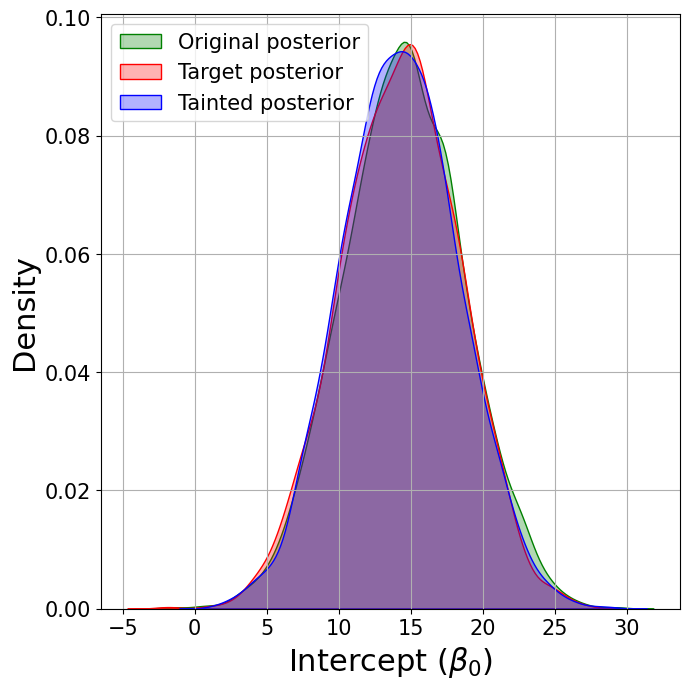

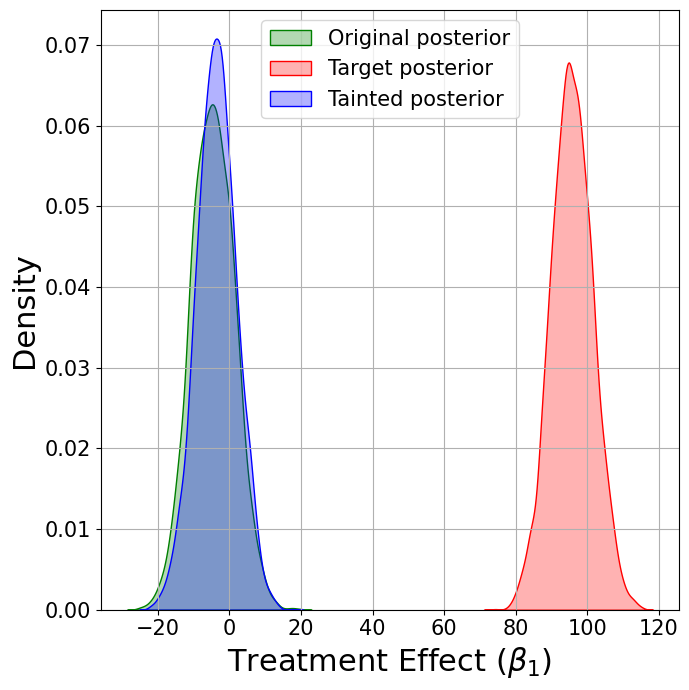

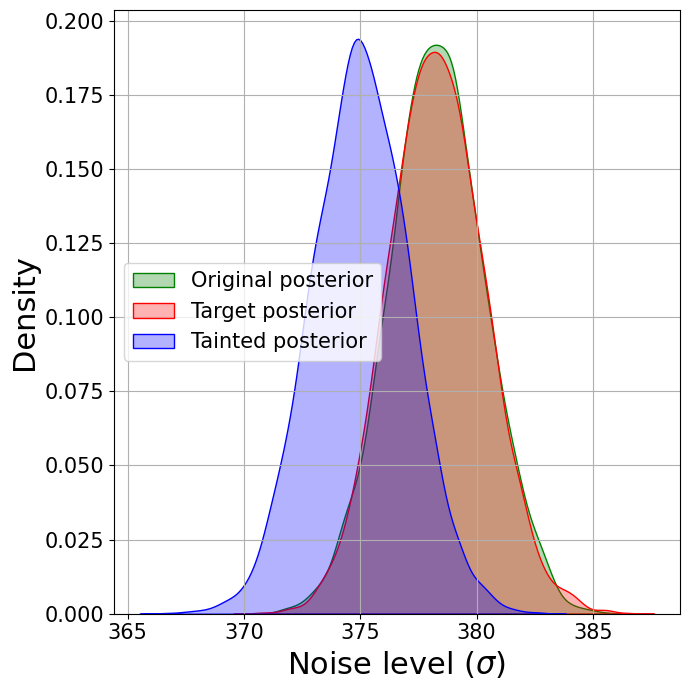

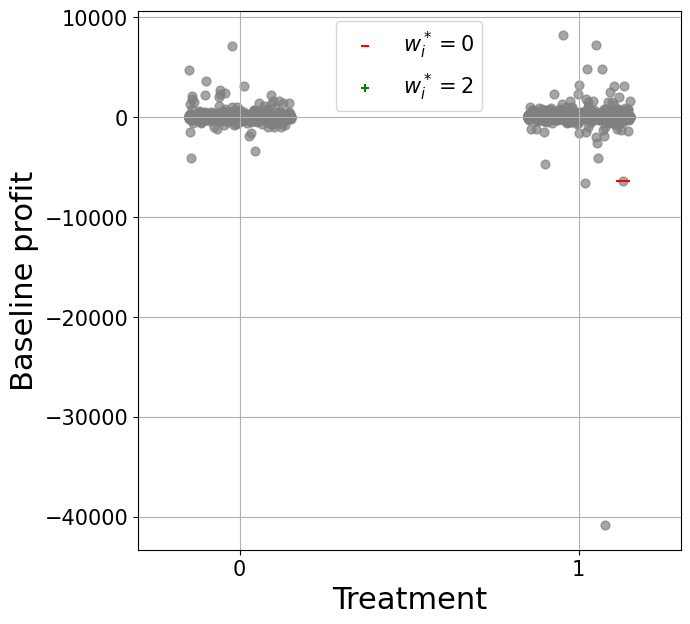

In [104]:
model.seed = 0
weights, samples_adv, samples_tainted = increase_slope(100, "2O-ISCD", plot=True,
                                                       n_MC_samples_adv=2000, n_MC_samples_post=2000,
                                                       n_samples_plot=5000)
plot_points(weights)

[<matplotlib.collections.PolyCollection object at 0x7f33cc7b4dd0>, <matplotlib.collections.PolyCollection object at 0x7f33301ebb30>, <matplotlib.collections.PolyCollection object at 0x7f33301eaba0>] ['Original posterior', 'Tainted posterior', 'Target posterior']


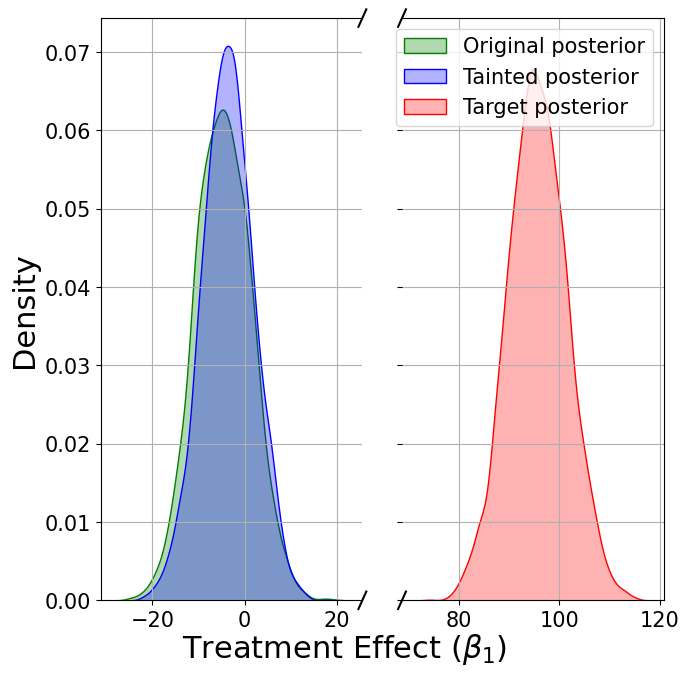

In [97]:
plot_samples_kde_single_param_break_lines(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=False,      
                            )

[<matplotlib.collections.PolyCollection object at 0x7f32f0245400>, <matplotlib.collections.PolyCollection object at 0x7f32f02dbe30>, <matplotlib.collections.PolyCollection object at 0x7f32f028c950>] ['Original posterior', 'Tainted posterior', 'Target posterior']


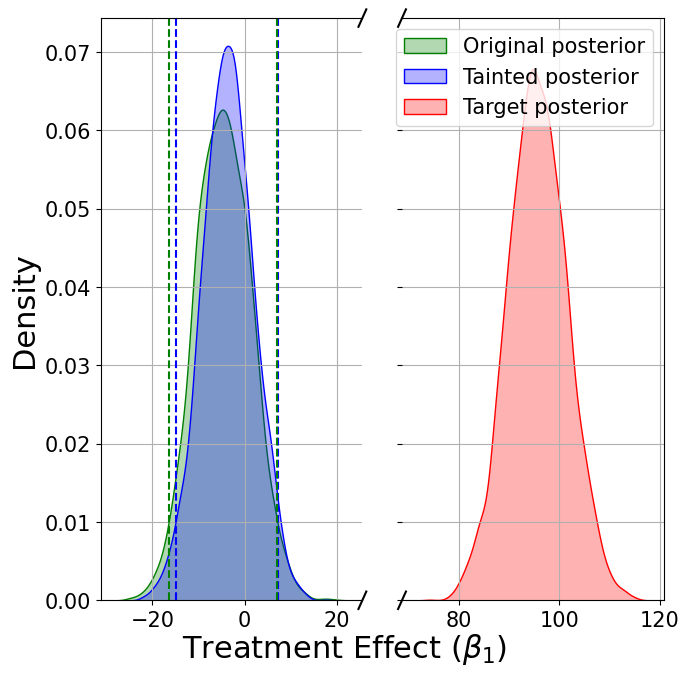

In [105]:
plot_samples_kde_single_param_break_lines(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=True,      
                            )

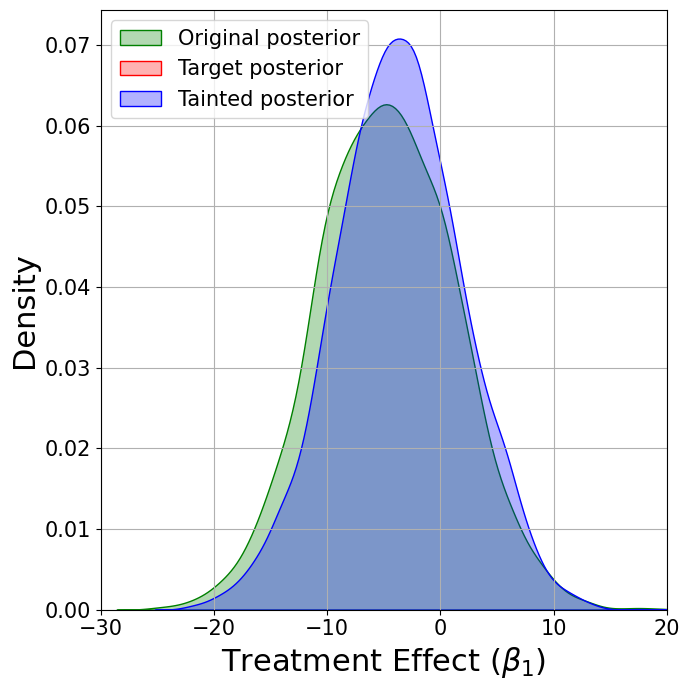

In [98]:
plot_samples_kde_single_param(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=False,
                            xlim=(-30, 20)          
                            )

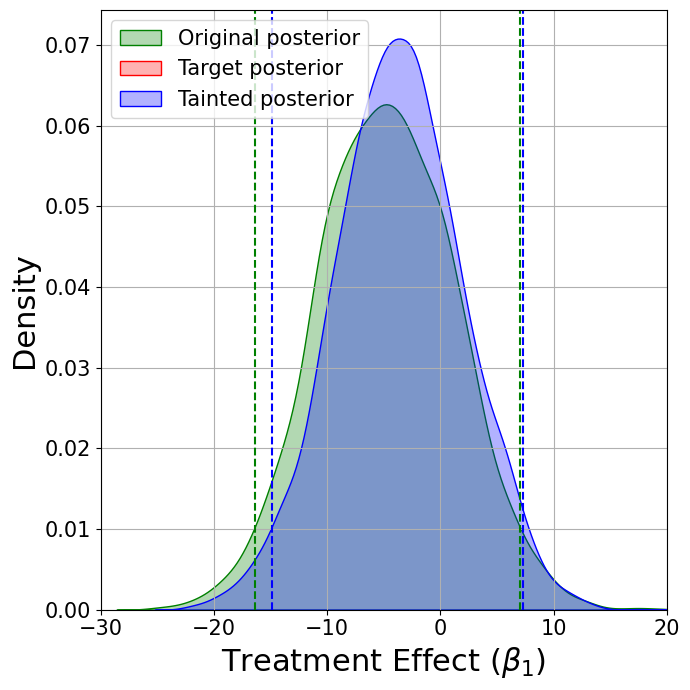

In [48]:
plot_samples_kde_single_param(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=True,
                            xlim=(-30, 20)          
                            )

## Change sign of $\mathbb{E}_{w^*}[\beta_1]$ with $B=1$ 

Number of points modified: 1
X=1.0, Y=-40854.421875, w=0
Beta_1 mean and std: 0.43204790353775024 +- 3.1937081813812256
95% confidence interval: [-5.875282335281372, 6.5520915865898095]


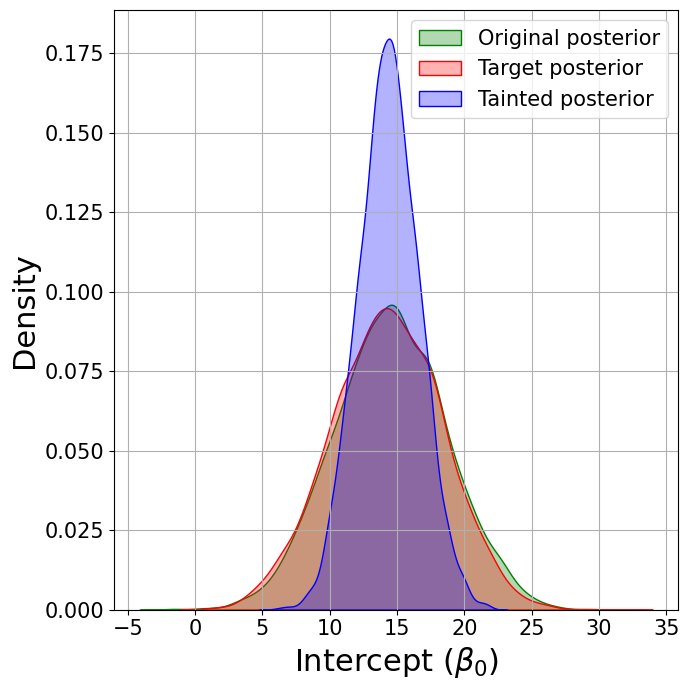

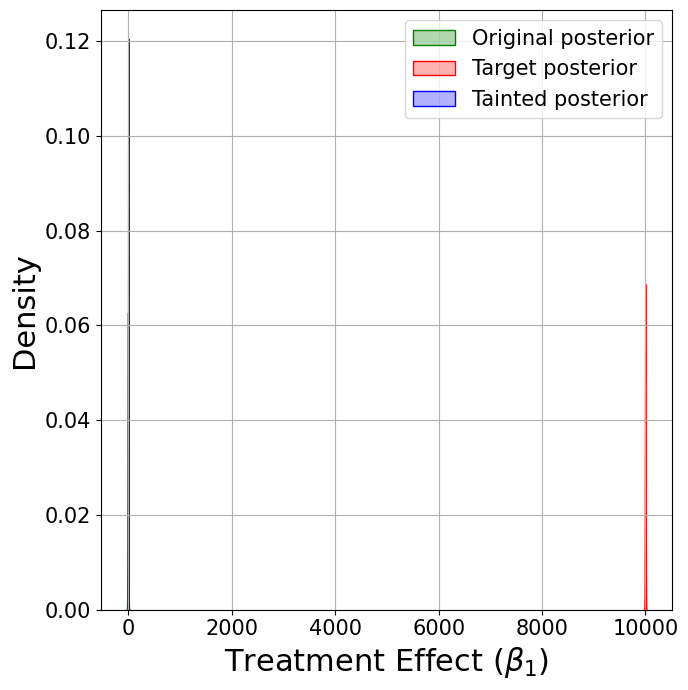

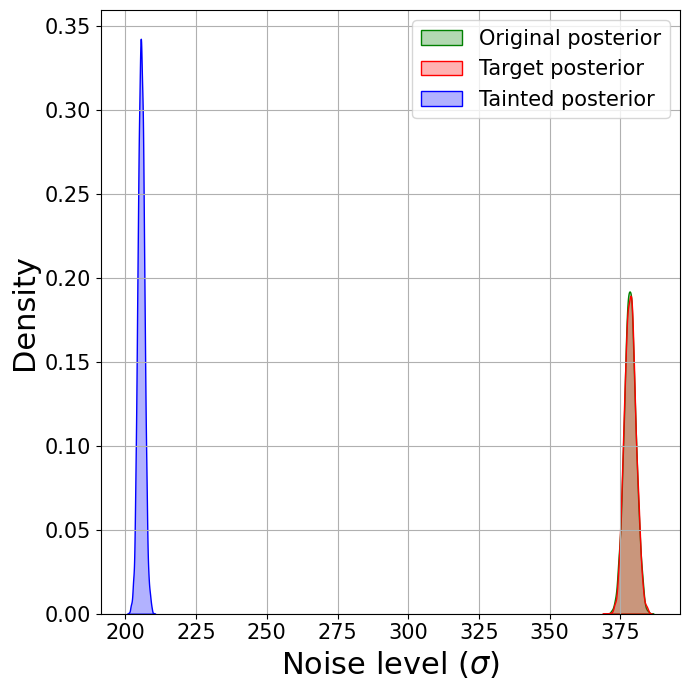

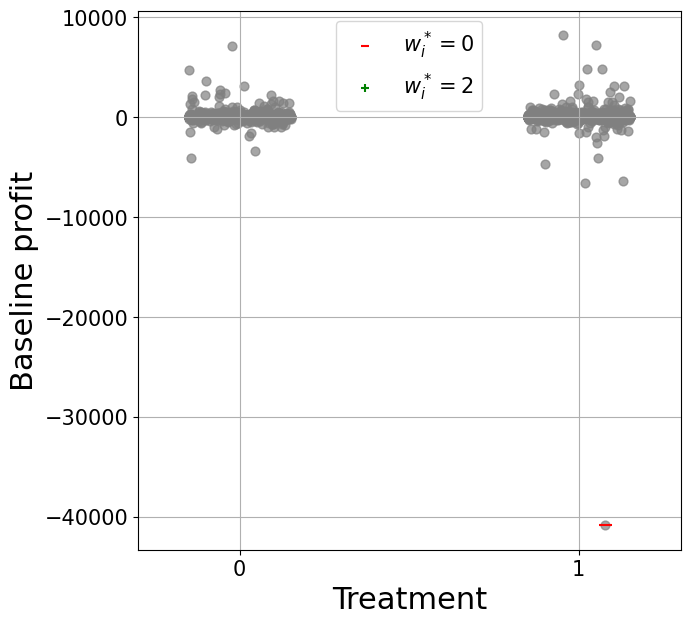

In [99]:
model.seed = 0
weights, samples_adv, samples_tainted = increase_slope(10000, "2O-ISCD", plot=True,
                                                       n_MC_samples_adv=2000, n_MC_samples_post=2000,
                                                       n_samples_plot=5000)
plot_points(weights)

[<matplotlib.collections.PolyCollection object at 0x7f33ec1835c0>, <matplotlib.collections.PolyCollection object at 0x7f338c48fb60>, <matplotlib.collections.PolyCollection object at 0x7f338c509f40>] ['Original posterior', 'Tainted posterior', 'Target posterior']


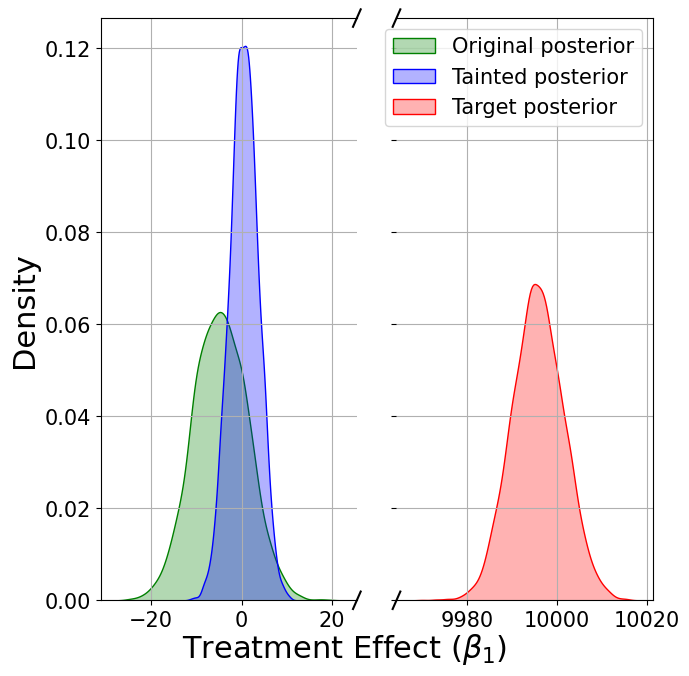

In [102]:
plot_samples_kde_single_param_break_lines(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=False,      
                            )

[<matplotlib.collections.PolyCollection object at 0x7f333015e5a0>, <matplotlib.collections.PolyCollection object at 0x7f3328367b90>, <matplotlib.collections.PolyCollection object at 0x7f33283ad310>] ['Original posterior', 'Tainted posterior', 'Target posterior']


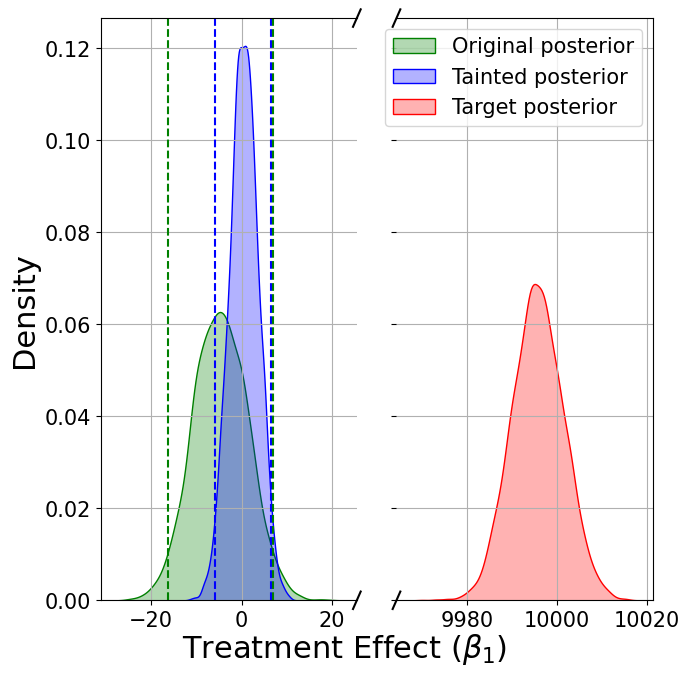

In [103]:
plot_samples_kde_single_param_break_lines(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=True,      
                            )

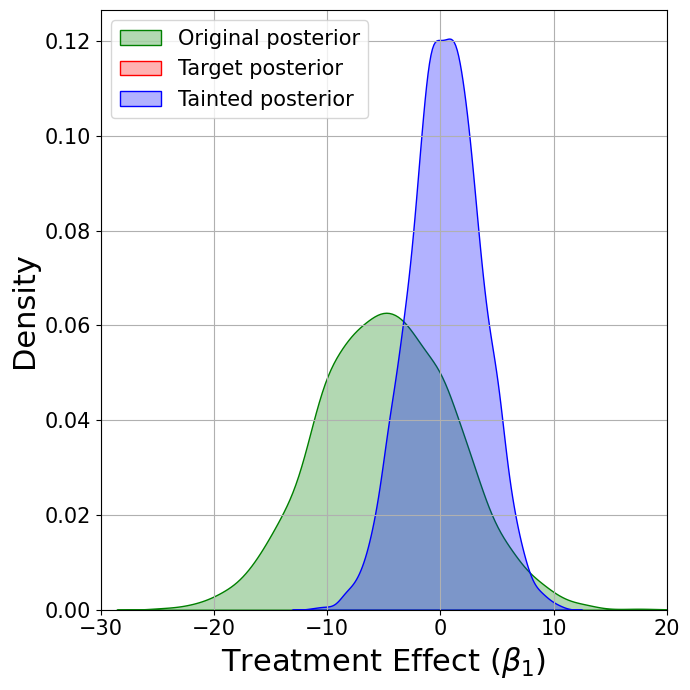

In [100]:
plot_samples_kde_single_param(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=False,
                            xlim=(-30, 20)          
                            )

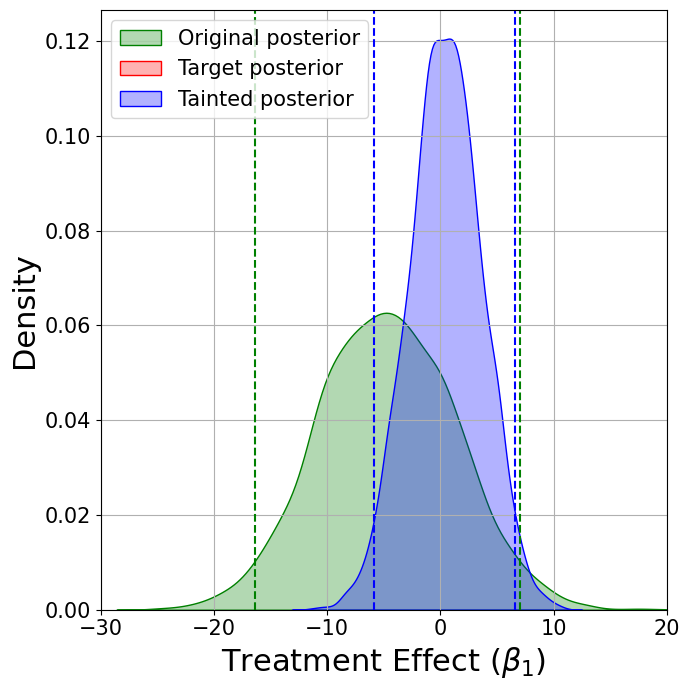

In [101]:
plot_samples_kde_single_param(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=True,
                            xlim=(-30, 20)          
                            )

## Make confidence interval entirely positive, i.e $\pi_{w^*}(\beta_1<0) < 0.025 $ with $B=20$

### Using FGSM

Number of points modified: 20
X=1.0, Y=-1437.0902099609375, w=0
X=1.0, Y=-1847.6873779296875, w=0
X=1.0, Y=-40854.421875, w=0
X=1.0, Y=-1231.7916259765625, w=0
X=1.0, Y=-1950.336669921875, w=0
X=1.0, Y=-1488.4149169921875, w=0
X=1.0, Y=-1157.8841552734375, w=0
X=1.0, Y=-1134.2747802734375, w=0
X=1.0, Y=-1026.4930419921875, w=0
X=1.0, Y=-1129.142333984375, w=0
X=1.0, Y=-4105.97216796875, w=0
X=1.0, Y=-1539.739501953125, w=0
X=1.0, Y=-1026.4930419921875, w=0
X=1.0, Y=-6569.55517578125, w=0
X=1.0, Y=-2584.70947265625, w=0
X=1.0, Y=-4721.86767578125, w=0
X=1.0, Y=-1334.44091796875, w=0
X=1.0, Y=-821.1943969726562, w=0
X=1.0, Y=-1324.176025390625, w=0
X=1.0, Y=-6364.2568359375, w=0
Beta_1 mean and std: 5.5680437088012695 +- 2.7743582725524902
95% confidence interval: [0.08710112739354392, 10.860036969184872]


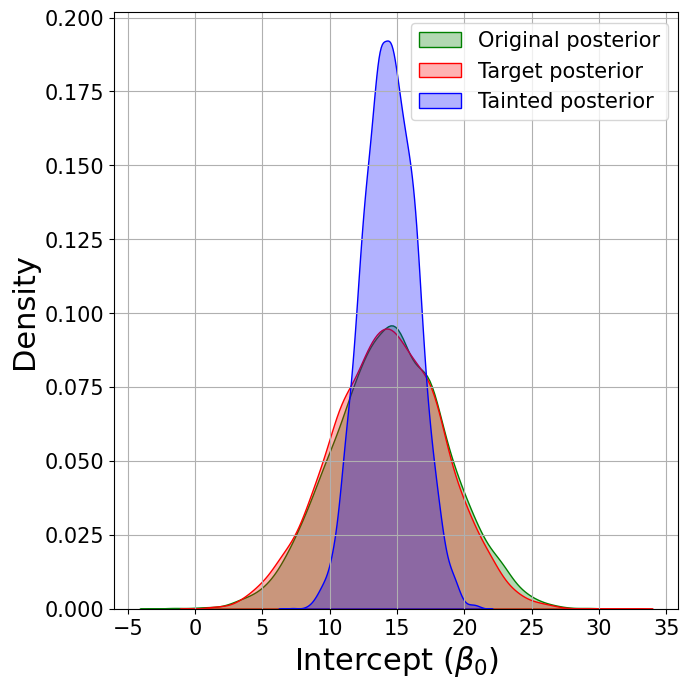

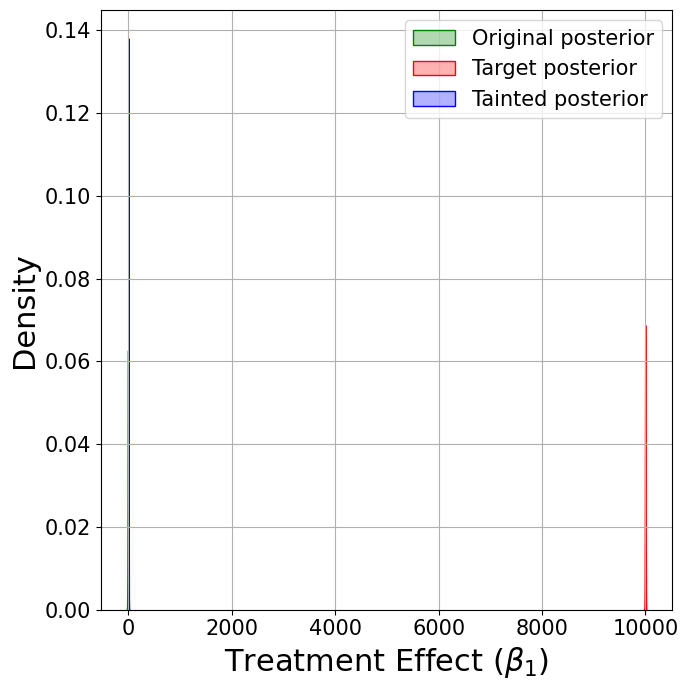

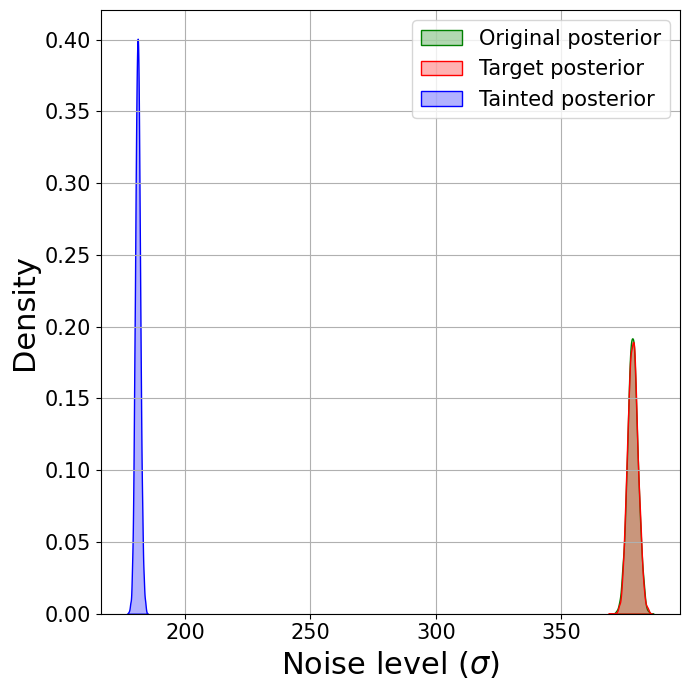

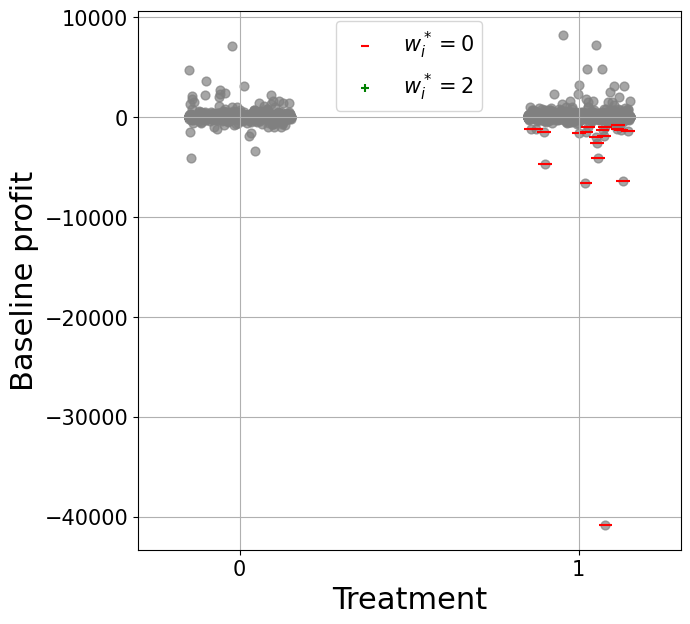

In [55]:
model.seed = 0
weights, samples_adv, samples_tainted = increase_slope(10000, "FGSM", plot=True,
                                                       max_L1=20, max_occurences=2,                                                        
                                                       n_MC_samples_adv=2000, n_MC_samples_post=2000,
                                                       n_samples_plot=5000)
plot_points(weights)

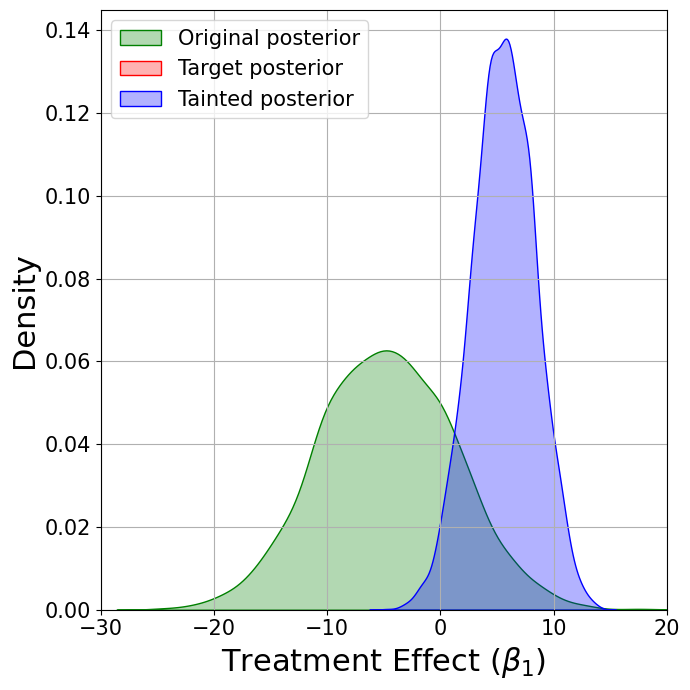

In [58]:
plot_samples_kde_single_param(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=False,
                            xlim=(-30, 20)          
                            )

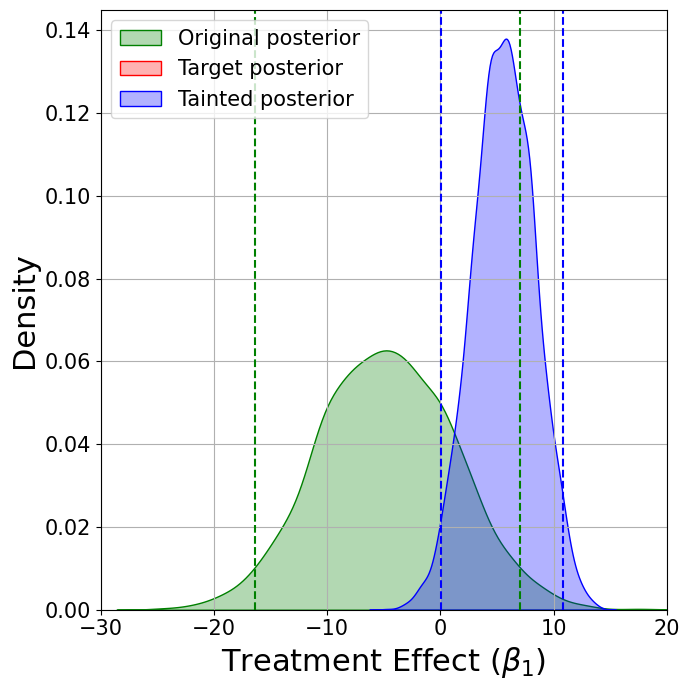

In [59]:
plot_samples_kde_single_param(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=True,
                            xlim=(-30, 20)          
                            )

### Using 2O-ISCD

inf params at iteration 1
inf params at iteration 2
inf params at iteration 3
inf params at iteration 4
inf params at iteration 5
inf params at iteration 6
inf params at iteration 7
inf params at iteration 8
inf params at iteration 9
inf params at iteration 10
inf params at iteration 11
inf params at iteration 12
inf params at iteration 13
inf params at iteration 14
inf params at iteration 15
inf params at iteration 16
inf params at iteration 17
inf params at iteration 18
inf params at iteration 19
inf params at iteration 20
Number of points modified: 20
X=1.0, Y=-1437.0902099609375, w=0
X=1.0, Y=-1847.6873779296875, w=0
X=1.0, Y=-40854.421875, w=0
X=1.0, Y=-1231.7916259765625, w=0
X=1.0, Y=-1950.336669921875, w=0
X=1.0, Y=-1488.4149169921875, w=0
X=1.0, Y=-1157.8841552734375, w=0
X=1.0, Y=-1134.2747802734375, w=0
X=1.0, Y=-1129.142333984375, w=0
X=0.0, Y=7082.8017578125, w=2
X=1.0, Y=-4105.97216796875, w=0
X=1.0, Y=-1539.739501953125, w=0
X=1.0, Y=-6569.55517578125, w=0
X=1.0, Y=-2584

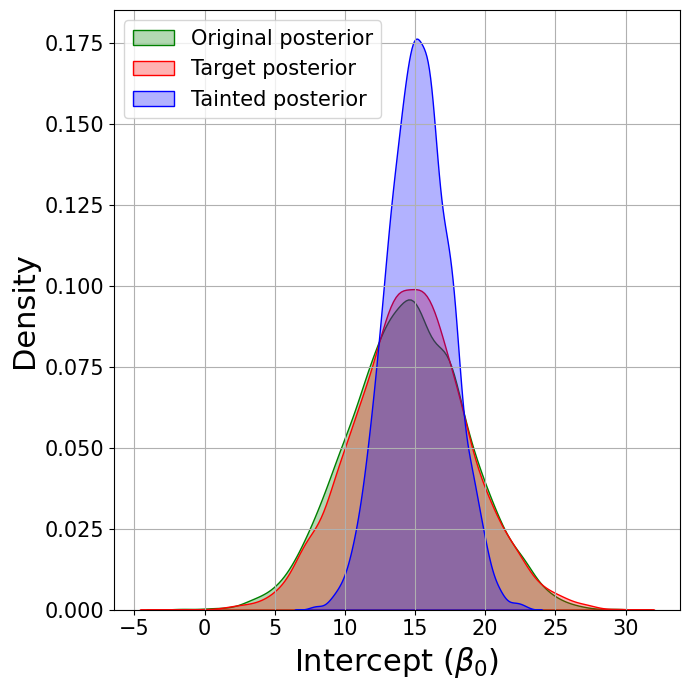

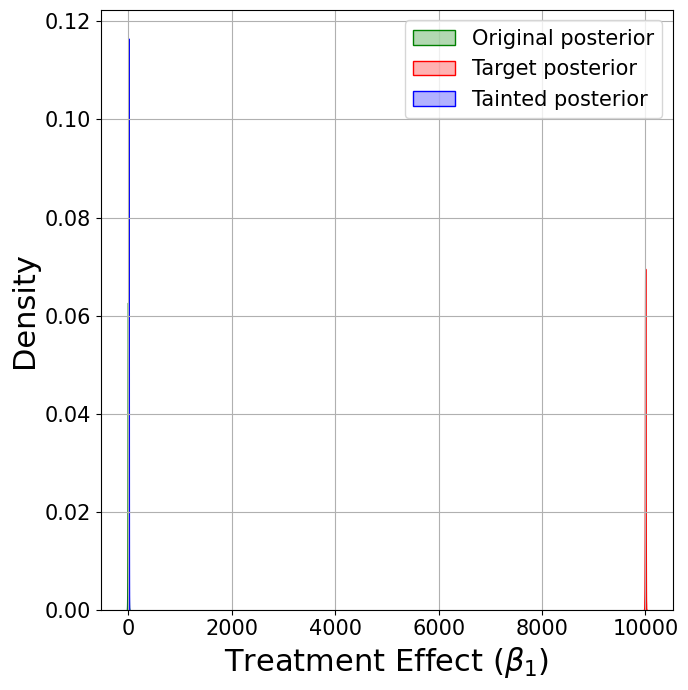

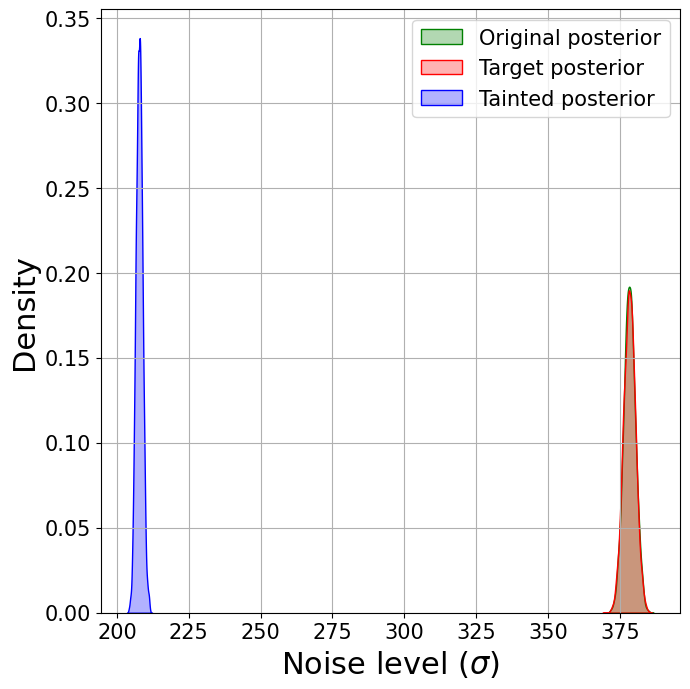

In [11]:
model.seed = 0
weights, samples_adv, samples_tainted = increase_slope(10000, "2O-ISCD", plot=True,
                                                       max_L1=20, max_iterations=25, max_occurences=2,                                         
                                                       n_MC_samples_adv=2000, n_MC_samples_post=500,
                                                       n_samples_plot=5000, 
                                                       warmup_steps=1000,
                                                       warmup_steps_repeat=500)

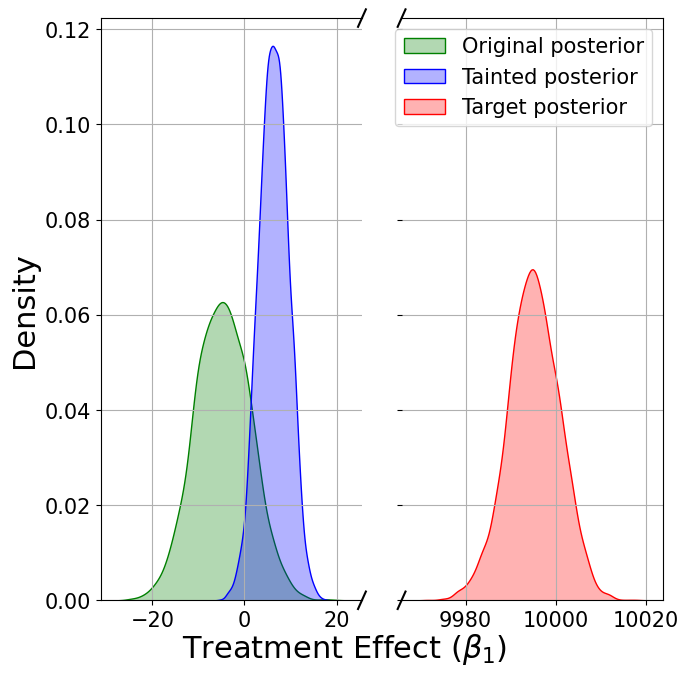

In [12]:
plot_samples_kde_single_param_break_lines(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=False,      
                            )

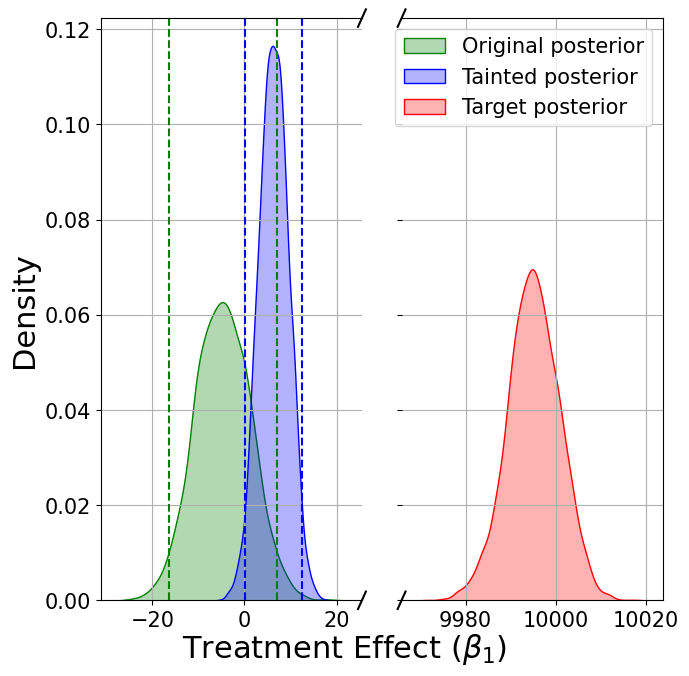

In [13]:
plot_samples_kde_single_param_break_lines(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=True,      
                            )

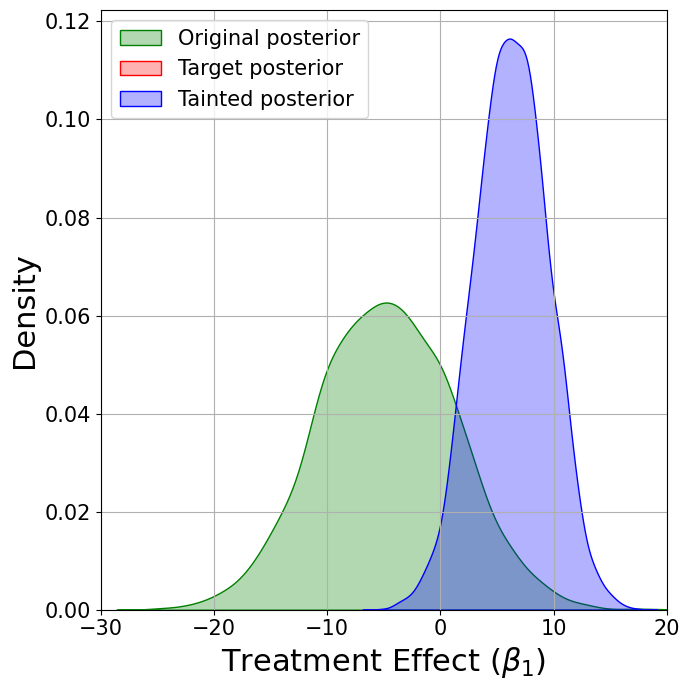

In [93]:
plot_samples_kde_single_param(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=False,
                            xlim=(-30, 20)          
                            )

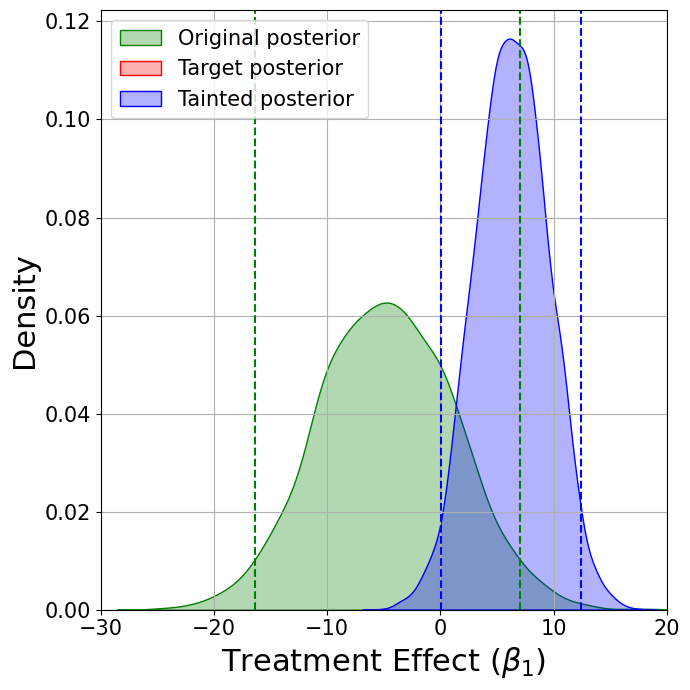

In [95]:
plot_samples_kde_single_param(samples_orig["beta_1"],
                            samples_adv["beta_1"],
                            samples_tainted["beta_1"],
                            xlabel="Treatment Effect ($\\beta_1$)",
                            confidence_interval=True,
                            xlim=(-30, 20)          
                            )

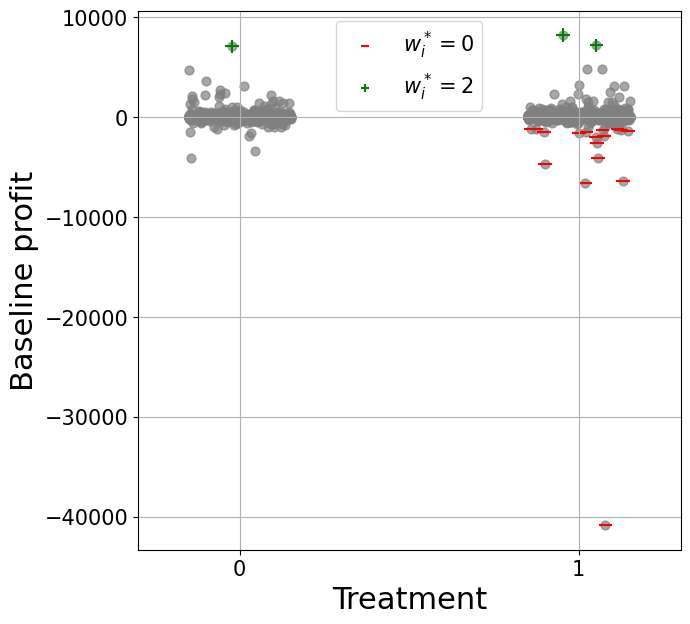

In [94]:
plot_points(weights)